# Martingales and the characteristic functions of absorption time on bipartite graphs

### Travis Monk, International Centre for Neuromorphic Systems, The MARCS Institute, Western Sydney University

This iPython notebook is freely available for all commercial and noncommercial use.  It accompanies the manuscript of the same title.  It reproduces all of the figures in the paper and saves them as pdf files.

One of those figures plots simulation results and compares them with theoretical analysis.  This notebook also runs simulations of the Moran process on the bipartite graph and saves them as .npz files to be loaded and plotted later.  If the .npz files exist in the same folder as this notebook, then the simulations do not run to expedite execution of this notebook.  To run simulations, simply delete or move the .npz files to another folder.

The preamble loads standard requisite packages and defines functions that will be called later.

The function 'fg' calculates the functions f(h) and g(h) that yield a product martingale.  The function 'psi' calculates the conditional characteristic functions of the number of mutant population size changes.  The function 'sims' runs simulations of the Moran process on the complete bipartite graph and saves the results as a .npz file.

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from sympy import *
from sympy.solvers.solveset import linsolve
from matplotlib.lines import Line2D
from os import path

plt.rcParams.update({"text.usetex": True,'font.size': 16})

def fg(A,B,r,h):
    
    AA = (r/A + B/A**2)
    BB = -(r/A + 1/B)*(1./h + B/(A*r*h)) - B*h/A**2 + h/B
    CC = (r/A + 1/B)*B/(A*r)

    f1 = (-BB + np.sqrt(BB**2 - 4*AA*CC))/(2*AA)
    f2 = (-BB - np.sqrt(BB**2 - 4*AA*CC))/(2*AA)
    
    g1 = (r/B + 1/A - 1/A*h*f1**(-1))*B/(r*h)
    g2 = (r/B + 1/A - 1/A*h*f2**(-1))*B/(r*h)
        
    return f1, f2, g1, g2

def psi(A,B,r,Sa0,Sb0,h):
        
    #calculate fixation probability.  get roots when g = 1:
    f0 = (A + B*r)/(r*(A*r + B)); g0 = (A*r + B)/(r*(A + B*r))
    
    #fixation probability is:
    p = (f0**Sa0*g0**Sb0 - 1)/(f0**A*g0**B - 1)
    
    #get the roots for general h:
    f1, f2, g1, g2 = fg(A,B,r,h)
    
    #calculate fixation CFs
    psia = (f1**Sa0*g1**Sb0 - f2**Sa0*g2**Sb0)/(p*(f1**A*g1**B - f2**A*g2**B))
    psib = (f2**Sa0*g2**Sb0*f1**A*g1**B - f1**Sa0*g1**Sb0*f2**A*g2**B)/((1-p)*(f1**A*g1**B - f2**A*g2**B))
    
    return psia, psib, p

def sims(A,B,r,Sa0,Sb0,tau,trials):

    #store results
    S_fix = 0; C_fix = []; S_ext = 0; C_ext = [];  T_fix = []; T_ext = []

    #define absorbing barriers
    fix = np.array([A,B]); ext = np.array([0,0])

    for i in range(trials):

        #reset initial conditions
        S = np.array([Sa0,Sb0]); C = 0; T = 0

        while (not np.array_equal(S,fix) and not np.array_equal(S,ext)):

            #draw a random number
            draw = np.random.uniform()

            #assemble probabilities that translate the random number to change in graph
            #total fitness
            F = r*(S[0] + S[1]) + (A-S[0]) + (B-S[1])

            #transition probabilities
            pbu = r*S[0]*(B-S[1])/(F*B); pbd = (A-S[0])*S[1]/(F*B)
            pau = r*S[1]*(A-S[0])/(F*A); pad = (B-S[1])*S[0]/(F*A)
            trans = np.cumsum([pbu,pbd,pau,pad,1-pbu-pbd-pau-pad])

            #find which transition you picked
            j = next(x[0] for x in enumerate(trans) if x[1] > draw)

            #change in graph and update clocks
            Xa = 1*(j==2) - 1*(j==3)
            Xb = 1*(j==0) - 1*(j==1)
            C += (j != 4); T += 1

            #update graph
            S[0] += Xa; S[1] += Xb

        #store results
        if np.array_equal(S,fix):
            S_fix += 1; C_fix.append(C); T_fix.append(T)
        if np.array_equal(S,ext):
            S_ext += 1; C_ext.append(C); T_ext.append(T)
            
    #Fourier transforms of results
    if len(C_fix) > 0:
        cfasim = np.array([np.mean(np.exp(np.array(C_fix)*j)) for j in tau])
        cfaT = np.array([np.mean(np.exp(np.array(T_fix)*j)) for j in tau])
    else:
        cfasim = 0
    if len(C_ext) > 0:
        cfbsim = np.array([np.mean(np.exp(np.array(C_ext)*j)) for j in tau])
        cfbT = np.array([np.mean(np.exp(np.array(T_ext)*j)) for j in tau])
    else:
        cfbsim = 0
            
    return S_fix, S_ext, cfasim, cfbsim, C_fix, C_ext, cfaT, cfbT, T_fix, T_ext

Fig. 1 is a schematic of our problem and notation.

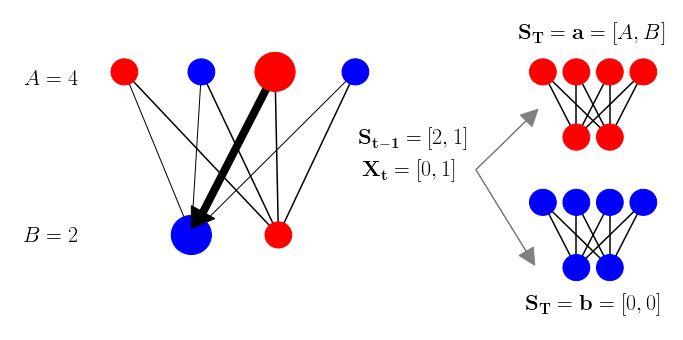

In [6]:
fig, ax = plt.subplots(figsize=(12,6))

x_plot = np.array([-.15,.05,.08,.3,.31,.54]); y_plot = np.array([.8,.3,.8,.8,.3,.8])
size = [.04,.06,.04,.06,.04,.04]; color = ['r','b','b','r','r','b']
ind = np.array([0,2,3,5])

x_fix = np.array([1.1,1.2,1.2,1.3,1.3,1.4]); y_fix = np.array([.8,.6,.8,.8,.6,.8])
y_ext = np.array([.4,.2,.4,.4,.2,.4])

#state change graph
[ax.add_artist(Line2D([i,.05],[.8,.3],color='k',zorder=0,linewidth = 8 if i==.3 else 1)) for i in x_plot[ind]];
[ax.add_artist(Line2D([i,.31],[.8,.3],color='k',zorder=0)) for i in x_plot[ind]];
[ax.add_artist(plt.Circle((i[0],i[1]), (i[2]), color=i[3])) for i in zip(x_plot,y_plot,size,color)];

#fixation graph
[ax.add_artist(Line2D([i,1.2],[.8,.6],color='k',zorder=0)) for i in x_fix[ind]];
[ax.add_artist(Line2D([i,1.3],[.8,.6],color='k',zorder=0)) for i in x_fix[ind]];
[ax.add_artist(plt.Circle((i[0],i[1]), (.04), color='r')) for i in zip(x_fix,y_fix)];

#extinction graph
[ax.add_artist(Line2D([i,1.2],[.4,.2],color='k',zorder=0)) for i in x_fix[ind]];
[ax.add_artist(Line2D([i,1.3],[.4,.2],color='k',zorder=0)) for i in x_fix[ind]];
[ax.add_artist(plt.Circle((i[0],i[1]), (.04), color='b')) for i in zip(x_fix,y_ext)];

tri = np.array([[.05, .32], [.05, .39], [.12, .35]])
triangle = plt.Polygon(tri,color='k',zorder=10)
plt.gca().add_patch(triangle)

plt.text(-.45,.76,r'$A=4$',fontsize=22)
plt.text(-.45,.28,r'$B=2$',fontsize=22)
plt.text(.55,.58,r'$\mathbf{S_{t-1}} = [2,1]$',fontsize=22)
plt.text(.56,.48,r'$\mathbf{X_{t}} = [0,1]$',fontsize=22)
plt.text(1.03,.9,r'$\mathbf{S_T} = \mathbf{a} = [A,B]$',fontsize=22)
plt.text(1.05,.07,r'$\mathbf{S_T} = \mathbf{b} = [0,0]$',fontsize=22)

ax.arrow(.9, .5, 0.15, 0.15, fc='gray', ec='gray', head_width=0.05, head_length=0.05)
ax.arrow(.9, .5, 0.15, -0.25, fc='gray', ec='gray', head_width=0.05, head_length=0.05)

ax.set_xlim([-.5,1.5]); ax.set_ylim([0,1])
ax.axis('off');

plt.savefig('schematic.pdf',bbox_inches='tight')

Fig. 2 plots the two pairs of functions $(f_1(h),g_1(h))$ and $(f_2(h),g_2(h))$ that yield a product martingale.  We substitute $h = e^\tau$, and plot the real and imaginary parts of all functions separately.

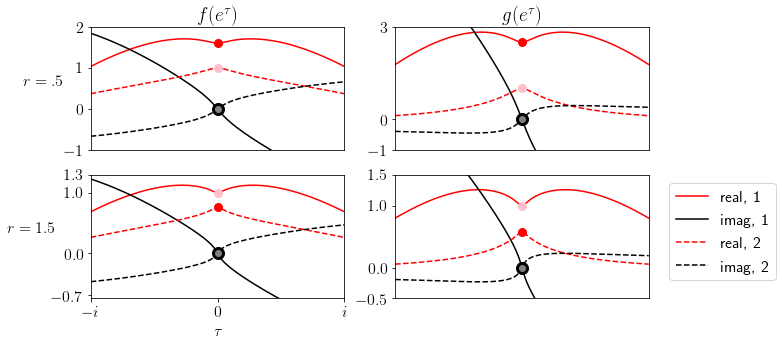

In [7]:
plt.figure(figsize=(10,5))

tau = np.linspace(-1,1,10000)*1j; h = np.exp(tau)

A = 3; B = 6

i = 1
for r in [0.5,1.5]:

    #parameters as a function of tau
    f1, f2, g1, g2 = fg(A,B,r,h)
    
    #values of parameters at tau = 0
    f0 = (A + B*r)/(r*(A*r + B)); g0 = (A*r + B)/(r*(A + B*r))

    plt.subplot(2,2,i);
    plt.plot(np.imag(tau),np.real(f1),'r'); plt.plot(np.imag(tau),np.imag(f1),'k')
    plt.plot(np.imag(tau),np.real(f2),'r--'); plt.plot(np.imag(tau),np.imag(f2),'k--')
    plt.plot(0,f0,'ro',markersize=8); plt.plot(0,0,'ko',markersize=12); plt.plot(0,0,'o',color='gray',markersize=6)
    plt.plot(0,1,'o',color='pink',markersize=8)
    plt.xlim([-1,1])
    if i == 1:
        plt.xticks([]); plt.ylim([-1,2]); plt.yticks([-1,0,1,2])
        plt.title(r'$f(e^\tau)$')
        plt.ylabel(r'$r = .5$',rotation=0,labelpad=20)
    if i == 3:
        plt.xticks([-1,0,1],[r'$-i$',r'$0$',r'$i$'])
        plt.ylim([-.75,1.3]); plt.yticks([-.7,0,1,1.3])
        plt.xlabel(r'$\tau$'); plt.ylabel(r'$r = 1.5$',rotation=0,labelpad=20)
    
    i += 1
    plt.subplot(2,2,i);
    plt.plot(np.imag(tau),np.real(g1),'r',label='real, 1'); plt.plot(np.imag(tau),np.imag(g1),'k',label='imag, 1')
    plt.plot(np.imag(tau),np.real(g2),'r--',label='real, 2'); plt.plot(np.imag(tau),np.imag(g2),'k--',label='imag, 2')
    plt.plot(0,g0,'ro',markersize=8); plt.plot(0,0,'ko',markersize=12); plt.plot(0,0,'o',color='gray',markersize=6)
    plt.plot(0,1,'o',color='pink',markersize=8)
    plt.xlim([-1,1]); plt.xticks([])
    if i == 2:
        plt.title(r'$g(e^\tau)$')
        plt.ylim([-1,3]); plt.yticks([-1,0,3])
    if i == 4:
        plt.ylim([-.5,1.5]); plt.yticks([-.5,0,1,1.5])
        plt.legend(bbox_to_anchor=(1.05, 1))

    i += 1
    
plt.savefig('roots.pdf',bbox_inches='tight')

If the relevant simulation .npz files are not in the same directory as this notebook, then run the simulation function for the parameter values stated in the manuscript and save the results.

In [8]:
if not path.exists("bipartite_sims_1.npz"):

    r = 3.; A = 10; B = 4; Sa0 = 1; Sb0 = 1; tau=np.linspace(-1,1,1000)*1j
    trials = 100000
    S_fix, S_ext, cfasim, cfbsim, C_fix, C_ext, cfaT, cfbT, T_fix, T_ext = sims(A,B,r,Sa0,Sb0,tau,trials)
    np.savez("bipartite_sims_1.npz",S_fix=S_fix,S_ext=S_ext,cfasim=cfasim,cfbsim=cfbsim,C_fix=C_fix,C_ext=C_ext,\
             A=A,B=B,r=r,Sa0=Sa0,Sb0=Sb0,tau=tau,T_fix=T_fix,T_ext=T_ext)
    
if not path.exists("bipartite_sims_2.npz"):

    r = .99; A = 10; B = 4; Sa0 = 1; Sb0 = 1; tau=np.linspace(-.25,.25,100)*1j
    trials = 100000
    S_fix, S_ext, cfasim, cfbsim, C_fix, C_ext, cfaT, cfbT, T_fix, T_ext = sims(A,B,r,Sa0,Sb0,tau,trials)
    np.savez("bipartite_sims_2.npz",S_fix=S_fix,S_ext=S_ext,cfasim=cfasim,cfbsim=cfbsim,C_fix=C_fix,C_ext=C_ext,\
             A=A,B=B,r=r,Sa0=Sa0,Sb0=Sb0,tau=tau,T_fix=T_fix,T_ext=T_ext)

Fig. 3 loads the simulation results and compares them with theoretical results for parameter values stated in the manuscript.

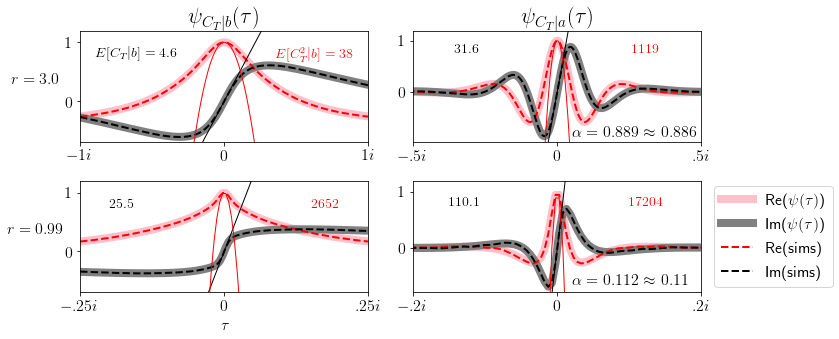

In [9]:
with np.load("bipartite_sims_1.npz") as data:
    S_fix = data['S_fix']; S_ext = data['S_ext']; cfasim = data['cfasim']; cfbsim = data['cfbsim'];
    C_fix = data['C_fix']; C_ext = data['C_ext'];
    A = data['A']; B = data['B']; r = data['r']; Sa0 = data['Sa0']; Sb0 = data['Sb0']; tau = data['tau']
    
h = np.exp(tau)    

#calculate theoretical CCFs
psia,psib,p = psi(A,B,r,Sa0,Sb0,h);

#simulation first and second moments of C_T
EC_ext = np.mean(C_ext); EC_fix = np.mean(C_fix)
EC2_ext = np.mean([i**2 for i in C_ext]); EC2_fix = np.mean([i**2 for i in C_fix])

plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(np.imag(tau),np.real(psib),color = 'pink',lw=8)
plt.plot(np.imag(tau),np.imag(psib),color='gray',lw=8)
plt.plot(np.imag(tau),np.real(cfbsim),'r--',lw=2)
plt.plot(np.imag(tau),np.imag(cfbsim),'k--',lw=2)
plt.title(r'$\psi_{C_T|b}(\tau)$',fontsize=22)
plt.xticks([-1,0,1],[r'$-1i$',r'$0$',r'$1i$']); plt.xlim([-1,1])
plt.yticks([0,1]); plt.ylim([-.7,1.2])
plt.ylabel(r'$r = {}$'.format(r), rotation=0, labelpad = 30)
plt.plot(np.imag(tau),np.imag(tau)*EC_ext,'k-',lw=1)
plt.plot(np.imag(tau),-EC2_ext*np.imag(tau)**2+1,'r-',lw=1)
plt.text(-.9,.75 ,r'$E[C_T|b] = {}$'.format(round(EC_ext,1)),fontsize=14)
plt.text(.35,.75 ,r'$E[C_T^2|b] = {}$'.format(int(EC2_ext)),fontsize=14,color='r')

plt.subplot(2,2,2)
plt.plot(np.imag(tau),np.real(psia),color = 'pink',lw=8)
plt.plot(np.imag(tau),np.imag(psia),color='gray',lw=8)
plt.plot(np.imag(tau),np.real(cfasim),'r--',lw=2)
plt.plot(np.imag(tau),np.imag(cfasim),'k--',lw=2)
plt.title(r'$\psi_{C_T|a}(\tau)$',fontsize=22)
plt.xticks([-.5,0,.5],[r'$-.5i$',r'$0$',r'$.5i$']); plt.xlim([-.5,.5])
plt.yticks([0,1]); plt.ylim([-1,1.2])
p_sim = float(S_fix)/(S_fix + S_ext)
plt.text(.05,-.87,r'$\alpha = {} \approx $'.format(round(p,3)) + ' ' + r'$ {}$'.format(round(p_sim,3)))
plt.plot(np.imag(tau),np.imag(tau)*EC_fix,'k-',lw=1)
plt.plot(np.imag(tau),-EC2_fix*np.imag(tau)**2+1,'r-',lw=1)
plt.text(-.36,.75 ,r'${}$'.format(round(EC_fix,1)),fontsize=14)
plt.text(.26,.75 ,r'${}$'.format(int(EC2_fix)),fontsize=14,color='r')

with np.load("bipartite_sims_2.npz") as data:
    S_fix = data['S_fix']; S_ext = data['S_ext']; cfasim = data['cfasim']; cfbsim = data['cfbsim'];
    C_fix = data['C_fix']; C_ext = data['C_ext'];
    A = data['A']; B = data['B']; r = data['r']; Sa0 = data['Sa0']; Sb0 = data['Sb0']; tau = data['tau']
    
h = np.exp(tau)
psia,psib,p = psi(A,B,r,Sa0,Sb0,h);

#simulation first and second moments of C_T
EC_ext = np.mean(C_ext); EC_fix = np.mean(C_fix)
EC2_ext = np.mean([i**2 for i in C_ext]); EC2_fix = np.mean([i**2 for i in C_fix])
    
plt.subplot(2,2,3)
plt.plot(np.imag(tau),np.real(psib),color = 'pink',lw=8)
plt.plot(np.imag(tau),np.imag(psib),color='gray',lw=8)
plt.plot(np.imag(tau),np.real(cfbsim),'r--',lw=2)
plt.plot(np.imag(tau),np.imag(cfbsim),'k--',lw=2)
plt.xticks([-.25,0,.25],[r'$-.25i$',r'$0$',r'$.25i$']); plt.xlim([-.25,.25])
plt.yticks([0,1]); plt.ylim([-.7,1.2])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$r = {}$'.format(r), rotation=0, labelpad = 30)
plt.plot(np.imag(tau),np.imag(tau)*EC_ext,'k-',lw=1)
plt.plot(np.imag(tau),-EC2_ext*np.imag(tau)**2+1,'r-',lw=1)
plt.text(-.2,.75 ,r'${}$'.format(round(EC_ext,1)),fontsize=14)
plt.text(.15,.75 ,r'${}$'.format(int(EC2_ext)),fontsize=14,color='r')

plt.subplot(2,2,4)
plt.plot(np.imag(tau),np.real(psia),color = 'pink',lw=8,label=r'Re($\psi(\tau)$)')
plt.plot(np.imag(tau),np.imag(psia),color='gray',lw=8,label=r'Im($\psi(\tau)$)')
plt.plot(np.imag(tau),np.real(cfasim),'r--',lw=2,label=r'Re(sims)')
plt.plot(np.imag(tau),np.imag(cfasim),'k--',lw=2,label=r'Im(sims)')
plt.xticks([-.2,0,.2],[r'$-.2i$',r'$0$',r'$.2i$']); plt.xlim([-.2,.2])
plt.yticks([0,1]); plt.ylim([-.8,1.2])
plt.legend(bbox_to_anchor=(1.25, .5),loc='center')
p_sim = float(S_fix)/(S_fix + S_ext)
plt.text(.02,-.67,r'$\alpha = {} \approx $'.format(round(p,3)) + ' ' + r'$ {}$'.format(round(p_sim,3)))
plt.plot(np.imag(tau),np.imag(tau)*EC_fix,'k-',lw=1)
plt.plot(np.imag(tau),-EC2_fix*np.imag(tau)**2+1,'r-',lw=1)
plt.text(-.15,.75 ,r'${}$'.format(round(EC_fix,1)),fontsize=14)
plt.text(.1,.75 ,r'${}$'.format(int(EC2_fix)),fontsize=14,color='r')

plt.tight_layout()
plt.savefig('CCFs.pdf',bbox_inches='tight')

Fig. 4 plots theoretical characteristic functions for varying population sizes.  We keep the proportion of individuals in each partition constant.

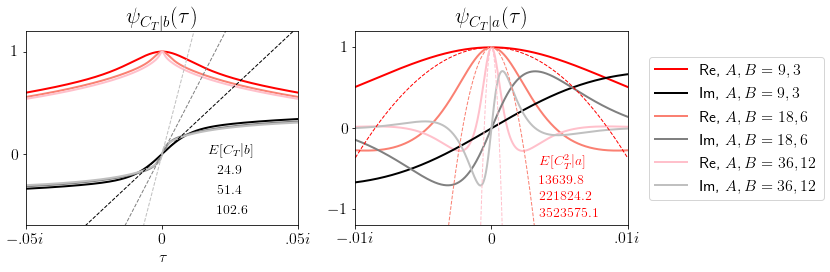

In [10]:
tau_a = np.linspace(-.01,.01,1000)*1j; tau_b = np.linspace(-.05,.05,1000)*1j

r = 1.01; A = [9,18,36]; B = [3,6,12]; Sa0 = 1; Sb0 = 1; h_a = np.exp(tau_a); h_b = np.exp(tau_b)
psia = []; psib = []; ECb = []; EC2a = []

r_color = ['r','salmon','pink']; i_color = ['k','gray','silver']

for i in range(3):    
    psia1,psib1,p = psi(A[i],B[i],r,Sa0,Sb0,h_a);
    psia.append(psia1); 
    psia2,psib2,p = psi(A[i],B[i],r,Sa0,Sb0,h_b);
    psib.append(psib2)
    EC2a.append(-1*np.gradient(np.gradient(np.real(psia[-1]),np.imag(tau_a)),np.imag(tau_a))[round((len(tau_a)-2)/2)])
    ECb.append(np.gradient(np.imag(psib[-1]),np.imag(tau_b))[round((len(tau_b)-1)/2)])

plt.figure(figsize=(12,7))
plt.clf()
plt.subplot(2,2,1)
[plt.plot(np.imag(tau_b),np.real(i[0]),color = i[1],lw=2,ls='-') for i in zip(psib,r_color,A,B)]
[plt.plot(np.imag(tau_b),np.imag(i[0]),color = i[1],lw=2,ls='-') for i in zip(psib,i_color)]
[plt.plot(np.imag(tau_b),i[0]*np.imag(tau_b),color = i[1],lw=1,ls='--') for i in zip(ECb,i_color)]
plt.title(r'$\psi_{C_T|b}(\tau)$',fontsize=22)
plt.xticks([-.05,0,.05],[r'$-.05i$',r'$0$',r'$.05i$']); plt.xlim([-.05,.05])
plt.yticks([0,1]); plt.ylim([-.7,1.2])
[plt.text(.02,i[0],r'${}$'.format(round(i[1],1)),fontsize=14,color='k') for i in zip([-.2,-.4,-.6],ECb)]
plt.text(.017,0,r'$E[C_T|b]$',fontsize=14)
plt.xlabel(r'$\tau$')

plt.subplot(2,2,2)
[plt.plot(np.imag(tau_a),np.real(i[0]),color = i[1],lw=2,ls='-',\
         label=r'Re, $A, B = {}, {}$'.format(i[2],i[3])) for i in zip(psia,r_color,A,B)]

[plt.plot(np.imag(tau_a),np.imag(i[0]),color = i[1],lw=2,ls='-',\
         label=r'Im, $A, B = {}, {}$'.format(i[2],i[3])) for i in zip(psia,i_color,A,B)]
[plt.plot(np.imag(tau_a),-i[0]*np.imag(tau_a)**2+1,color = i[1],lw=1,ls='--') for i in zip(EC2a,r_color)]
plt.title(r'$\psi_{C_T|a}(\tau)$',fontsize=22)
plt.xlim([-.01,.01])
plt.xticks([-.01,0,.01],[r'$-.01i$',r'$0$',r'$.01i$']); 
plt.yticks([-1,0,1]); 
plt.ylim([-1.2,1.2])
[plt.text(.0035,i[0],r'${}$'.format(round(i[1],1)),fontsize=14,color='r') for i in zip([-.7,-.9,-1.1],EC2a)]
plt.text(.0035,-.45,r'$E[C_T^2|a]$',fontsize=14,color='r')
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,4,2,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.4, .5),loc='center')

plt.tight_layout()
plt.savefig('sizes.pdf',bbox_inches='tight')

Fig. 5 plots the theoretical characteristic functions for bipartite graphs with constant total population size ($A+B=12$), but we vary how many individuals are allocated to each partition.  Note that $(A,B) = (6,6)$ is an isothermal graph.  Its conditional characteristic functions of population size changes are equivalent to those of the fully-connected Moran process.

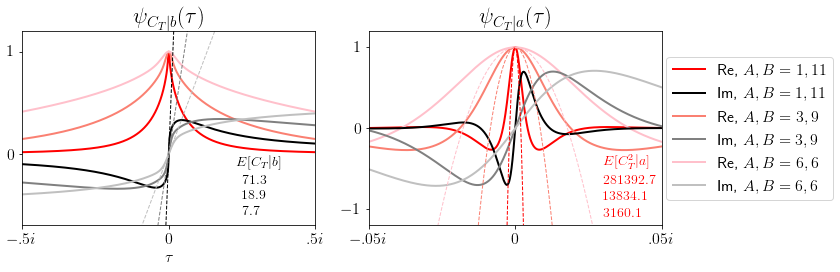

In [11]:
tau_a = np.linspace(-.05,.05,1000)*1j; tau_b = np.linspace(-.5,.5,1000)*1j

r = 1.01; A = [1,3,6]; B = [11,9,6]; Sa0 = 0; Sb0 = 1; h_a = np.exp(tau_a); h_b = np.exp(tau_b)
psia = []; psib = []; ECb = []; EC2a = []

r_color = ['r','salmon','pink']; i_color = ['k','gray','silver']

for i in range(3):    
    psia1,psib1,p = psi(A[i],B[i],r,Sa0,Sb0,h_a);
    psia.append(psia1); 
    psia2,psib2,p = psi(A[i],B[i],r,Sa0,Sb0,h_b);
    psib.append(psib2)
    EC2a.append(-1*np.gradient(np.gradient(np.real(psia[-1]),np.imag(tau_a)),np.imag(tau_a))[round((len(tau_a)-2)/2)])
    ECb.append(np.gradient(np.imag(psib[-1]),np.imag(tau_b))[round((len(tau_b)-1)/2)])

plt.figure(figsize=(12,7))
plt.clf()
plt.subplot(2,2,1)
[plt.plot(np.imag(tau_b),np.real(i[0]),color = i[1],lw=2,ls='-') for i in zip(psib,r_color,A,B)]
[plt.plot(np.imag(tau_b),np.imag(i[0]),color = i[1],lw=2,ls='-') for i in zip(psib,i_color)]
[plt.plot(np.imag(tau_b),i[0]*np.imag(tau_b),color = i[1],lw=1,ls='--') for i in zip(ECb,i_color)]
plt.title(r'$\psi_{C_T|b}(\tau)$',fontsize=22)
plt.xticks([-.5,0,.5],[r'$-.5i$',r'$0$',r'$.5i$']); plt.xlim([-.5,.5])
plt.yticks([0,1]); plt.ylim([-.7,1.2])
[plt.text(.25,i[0],r'${}$'.format(round(i[1],1)),fontsize=14,color='k') for i in zip([-.3,-.45,-.6],ECb)]
plt.text(.23,-.12,r'$E[C_T|b]$',fontsize=14)
plt.xlabel(r'$\tau$')

plt.subplot(2,2,2)
[plt.plot(np.imag(tau_a),np.real(i[0]),color = i[1],lw=2,ls='-',\
         label=r'Re, $A, B = {}, {}$'.format(i[2],i[3])) for i in zip(psia,r_color,A,B)]

[plt.plot(np.imag(tau_a),np.imag(i[0]),color = i[1],lw=2,ls='-',\
         label=r'Im, $A, B = {}, {}$'.format(i[2],i[3])) for i in zip(psia,i_color,A,B)]
[plt.plot(np.imag(tau_a),-i[0]*np.imag(tau_a)**2+1,color = i[1],lw=1,ls='--') for i in zip(EC2a,r_color)]
plt.title(r'$\psi_{C_T|a}(\tau)$',fontsize=22)
plt.xlim([-.05,.05])
plt.xticks([-.05,0,.05],[r'$-.05i$',r'$0$',r'$.05i$']); 
plt.yticks([-1,0,1]); 
plt.ylim([-1.2,1.2])
[plt.text(.03,i[0],r'${}$'.format(round(i[1],1)),fontsize=14,color='r') for i in zip([-.7,-.9,-1.1],EC2a)]
plt.text(.03,-.45,r'$E[C_T^2|a]$',fontsize=14,color='r')
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,4,2,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.3, .5),loc='center')

plt.tight_layout()
plt.savefig('asymmetry.pdf',bbox_inches='tight')

Fig. 6 plots the theoretical characteristic functions for varying initial mutant population sizes.

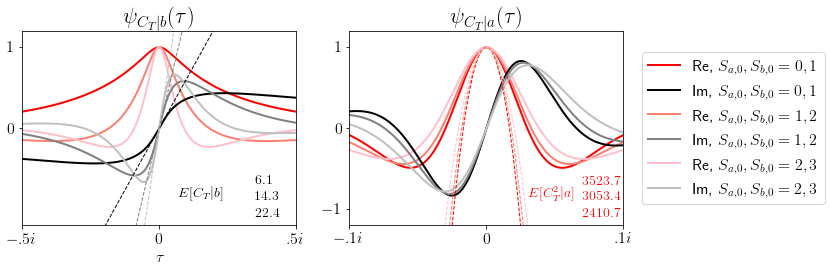

In [12]:
tau_a = np.linspace(-.1,.1,1000)*1j; tau_b = np.linspace(-.5,.5,1000)*1j

r = 2; A = 3; B = 10; Sa0 = [0,1,2]; Sb0 = [1,2,3]; h_a = np.exp(tau_a); h_b = np.exp(tau_b)
psia = []; psib = []; ECb = []; EC2a = []

r_color = ['r','salmon','pink']; i_color = ['k','gray','silver']

for i in range(3):    
    psia1,psib1,p = psi(A,B,r,Sa0[i],Sb0[i],h_a);
    psia.append(psia1); 
    psia2,psib2,p = psi(A,B,r,Sa0[i],Sb0[i],h_b);
    psib.append(psib2)
    EC2a.append(-1*np.gradient(np.gradient(np.real(psia[-1]),np.imag(tau_a)),np.imag(tau_a))[round((len(tau_a)-2)/2)])
    ECb.append(np.gradient(np.imag(psib[-1]),np.imag(tau_b))[round((len(tau_b)-1)/2)])

plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
[plt.plot(np.imag(tau_b),np.real(i[0]),color = i[1],lw=2,ls='-') for i in zip(psib,r_color)]
[plt.plot(np.imag(tau_b),np.imag(i[0]),color = i[1],lw=2,ls='-') for i in zip(psib,i_color)]
[plt.plot(np.imag(tau_b),i[0]*np.imag(tau_b),color = i[1],lw=1,ls='--') for i in zip(ECb,i_color)]
plt.title(r'$\psi_{C_T|b}(\tau)$',fontsize=22)
[plt.text(.35,i[0],r'${}$'.format(round(i[1],1)),fontsize=14,color='k') for i in zip([-.7,-.9,-1.1],ECb)]
plt.text(.07,-.85,r'$E[C_T|b]$',fontsize=14)
plt.xticks([-.5,0,.5],[r'$-.5i$',r'$0$',r'$.5i$']); plt.xlim([-.5,.5])
plt.yticks([0,1]); plt.ylim([-1.2,1.2])
plt.xlabel(r'$\tau$')


plt.subplot(2,2,2)

[plt.plot(np.imag(tau_a),np.real(i[0]),color = i[1],lw=2,ls='-',\
         label=r'Re, $S_{{a,0}}, S_{{b,0}} = {}, {}$'.format(i[2],i[3])) for i in zip(psia,r_color,Sa0,Sb0)]

[plt.plot(np.imag(tau_a),np.imag(i[0]),color = i[1],lw=2,ls='-',\
         label=r'Im, $S_{{a,0}}, S_{{b,0}} = {}, {}$'.format(i[2],i[3])) for i in zip(psia,i_color,Sa0,Sb0)]

[plt.plot(np.imag(tau_a),-i[0]*np.imag(tau_a)**2+1,color = i[1],lw=1,ls='--') for i in zip(EC2a,r_color)]
plt.title(r'$\psi_{C_T|a}(\tau)$',fontsize=22)
[plt.text(.07,i[0],r'${}$'.format(round(i[1],1)),fontsize=14,color='r') for i in zip([-.7,-.9,-1.1],EC2a)]
plt.text(.03,-.85,r'$E[C_T^2|a]$',fontsize=14,color='r')
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,4,2,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.4, .5),loc='center')
plt.xlim([-.1,.1]); plt.xticks([-.1,0,.1],[r'$-.1i$',r'$0$',r'$.1i$']); 
plt.yticks([-1,0,1]); plt.ylim([-1.2,1.2])

plt.tight_layout()
plt.savefig('start.pdf',bbox_inches='tight')

Fig. 7 compares our theoretical characteristic functions of the number of population size changes with those of absorption time.  We obtain the characteristic functions of absorption time from simulations.  If those simulations don't exist in the same directory as this notebook, then run them for the parameter values stated in the manuscript.

In [13]:
if not path.exists("bipartite_sims_3.npz"):

    r = 1.01; A = 4; B = 6; Sa0 = 1; Sb0 = 0; tau=np.linspace(-1,1,1000)*1j
    trials = 200000
    S_fix, S_ext, cfasim, cfbsim, C_fix, C_ext, cfaT, cfbT, T_fix, T_ext = sims(A,B,r,Sa0,Sb0,tau,trials)
    np.savez("bipartite_sims_3.npz",S_fix=S_fix,S_ext=S_ext,cfasim=cfasim,cfbsim=cfbsim,C_fix=C_fix,C_ext=C_ext,\
             A=A,B=B,r=r,Sa0=Sa0,Sb0=Sb0,tau=tau,T_fix=T_fix,T_ext=T_ext,cfaT=cfaT,cfbT=cfbT)
    
if not path.exists("bipartite_sims_4.npz"):

    r = 1.01; A = 9; B = 1; Sa0 = 1; Sb0 = 0; tau=np.linspace(-1,1,10000)*1j
    trials = 200000
    S_fix, S_ext, cfasim, cfbsim, C_fix, C_ext, cfaT, cfbT, T_fix, T_ext = sims(A,B,r,Sa0,Sb0,tau,trials)
    np.savez("bipartite_sims_4.npz",S_fix=S_fix,S_ext=S_ext,cfasim=cfasim,cfbsim=cfbsim,C_fix=C_fix,C_ext=C_ext,\
             A=A,B=B,r=r,Sa0=Sa0,Sb0=Sb0,tau=tau,T_fix=T_fix,T_ext=T_ext,cfaT=cfaT,cfbT=cfbT)

Fig. 7 compares theoretical characteristic functions of $C_T$ with those of $T$ in the region of weak selection ($r=1.01$).

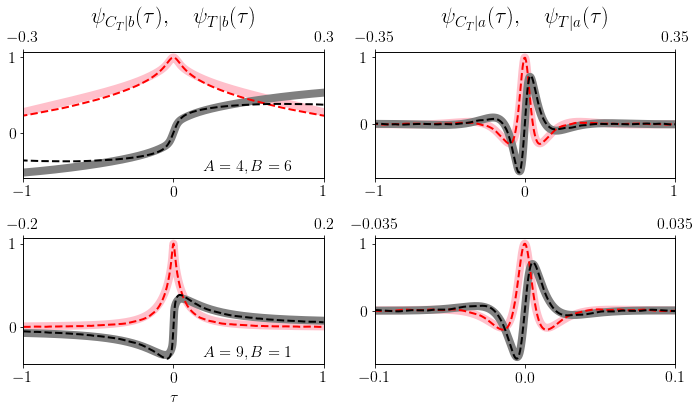

In [14]:
with np.load("bipartite_sims_3.npz") as data:
    S_fix = data['S_fix']; S_ext = data['S_ext']; cfasim = data['cfasim']; cfbsim = data['cfbsim'];
    C_fix = data['C_fix']; C_ext = data['C_ext'];
    A = data['A']; B = data['B']; r = data['r']; Sa0 = data['Sa0']; Sb0 = data['Sb0']; tau = data['tau']
    cfaT = data['cfaT']; cfbT = data['cfbT']
    
h = np.exp(tau)    

#calculate theoretical CCFs
psia,psib,p = psi(A,B,r,Sa0,Sb0,h);

fig = plt.subplots(figsize=(10,6))
ax1 = plt.subplot(221); ax2 = plt.subplot(222); ax3 = plt.subplot(223); ax4 = plt.subplot(224)
ax1b = ax1.twiny(); ax2b = ax2.twiny(); ax3b = ax3.twiny(); ax4b = ax4.twiny()

ax1.plot(np.imag(tau),np.real(psib),color = 'pink',lw=8)
ax1.plot(np.imag(tau),np.imag(psib),color='gray',lw=8)
ax1.set_xticks([-1,0,1]); ax1.set_xlim([-1,1])
ax1.set_title(r'$\psi_{C_T|b}(\tau), \quad \psi_{T|b}(\tau)$',fontsize=22)
ax1b.plot(np.imag(tau),np.real(cfbT),color='r',lw=2,ls='--')
ax1b.plot(np.imag(tau),np.imag(cfbT),color='k',lw=2,ls='--')
ax1b.set_xticks([-.3,.3]); ax1b.set_xlim([-.3,.3])
ax1.set_yticks([0,1])
ax1.text(.2,-.5,r'$A=4, B=6$')

ax2.plot(np.imag(tau),np.real(psia),color = 'pink',lw=8)
ax2.plot(np.imag(tau),np.imag(psia),color='gray',lw=8)
ax2.set_title(r'$\psi_{C_T|a}(\tau), \quad \psi_{T|a}(\tau)$',fontsize=22)
ax2b.plot(np.imag(tau),np.real(cfaT),color='r',lw=2,ls='--')
ax2b.plot(np.imag(tau),np.imag(cfaT),color='k',lw=2,ls='--')
ax2b.set_xlim([-.35,.35]); ax2b.set_xticks([-.35,.35])
ax2.set_xlim([-1,1]); ax2.set_xticks([-1,0,1]); ax2.set_yticks([0,1])


with np.load("bipartite_sims_4.npz") as data:
    S_fix = data['S_fix']; S_ext = data['S_ext']; cfasim = data['cfasim']; cfbsim = data['cfbsim'];
    C_fix = data['C_fix']; C_ext = data['C_ext'];
    A = data['A']; B = data['B']; r = data['r']; Sa0 = data['Sa0']; Sb0 = data['Sb0']; tau = data['tau']
    cfaT = data['cfaT']; cfbT = data['cfbT']
    
h = np.exp(tau)    

#calculate theoretical CCFs
psia,psib,p = psi(A,B,r,Sa0,Sb0,h);

ax3.plot(np.imag(tau),np.real(psib),color = 'pink',lw=8)
ax3.plot(np.imag(tau),np.imag(psib),color='gray',lw=8)
ax3.set_xticks([-1,0,1]); ax3.set_xlim([-1,1])
ax3b.plot(np.imag(tau),np.real(cfbT),color='r',lw=2,ls='--')
ax3b.plot(np.imag(tau),np.imag(cfbT),color='k',lw=2,ls='--')
ax3b.set_xticks([-.2,.2]); ax3b.set_xlim([-.2,.2])
ax3.set_yticks([0,1])
ax3.set_xlabel(r'$\tau$')
ax3.text(.2,-.35,r'$A=9,B=1$')

ax4.plot(np.imag(tau),np.real(psia),color = 'pink',lw=8)
ax4.plot(np.imag(tau),np.imag(psia),color='gray',lw=8)
ax4b.plot(np.imag(tau),np.real(cfaT),color='r',lw=2,ls='--')
ax4b.plot(np.imag(tau),np.imag(cfaT),color='k',lw=2,ls='--')
ax4b.set_xlim([-.035,.035]); ax4b.set_xticks([-.035,.035])
ax4.set_xlim([-.1,.1]); ax4.set_xticks([-.1,0,.1]); ax4.set_yticks([0,1])


plt.tight_layout()
plt.savefig('time1.pdf',bbox_inches='tight')

Fig. 8 also compares our theoretical characteristic functions with simulation results, but for strong selection.  If simulation results don't exist in the current directory, then run the simulations for the parameter values stated in the manuscript.

In [15]:
if not path.exists("bipartite_sims_5.npz"):

    r = 3.; A = 4; B = 6; Sa0 = 1; Sb0 = 0; tau=np.linspace(-1,1,1000)*1j
    trials = 200000
    S_fix, S_ext, cfasim, cfbsim, C_fix, C_ext, cfaT, cfbT, T_fix, T_ext = sims(A,B,r,Sa0,Sb0,tau,trials)
    np.savez("bipartite_sims_5.npz",S_fix=S_fix,S_ext=S_ext,cfasim=cfasim,cfbsim=cfbsim,C_fix=C_fix,C_ext=C_ext,\
             A=A,B=B,r=r,Sa0=Sa0,Sb0=Sb0,tau=tau,T_fix=T_fix,T_ext=T_ext,cfaT=cfaT,cfbT=cfbT)
    
if not path.exists("bipartite_sims_6.npz"):

    r = 3.; A = 9; B = 1; Sa0 = 1; Sb0 = 0; tau=np.linspace(-1,1,10000)*1j
    trials = 200000
    S_fix, S_ext, cfasim, cfbsim, C_fix, C_ext, cfaT, cfbT, T_fix, T_ext = sims(A,B,r,Sa0,Sb0,tau,trials)
    np.savez("bipartite_sims_6.npz",S_fix=S_fix,S_ext=S_ext,cfasim=cfasim,cfbsim=cfbsim,C_fix=C_fix,C_ext=C_ext,\
             A=A,B=B,r=r,Sa0=Sa0,Sb0=Sb0,tau=tau,T_fix=T_fix,T_ext=T_ext,cfaT=cfaT,cfbT=cfbT)

Fig. 8 is analogous to Fig. 7, but in the region of strong selection ($r = 3$).

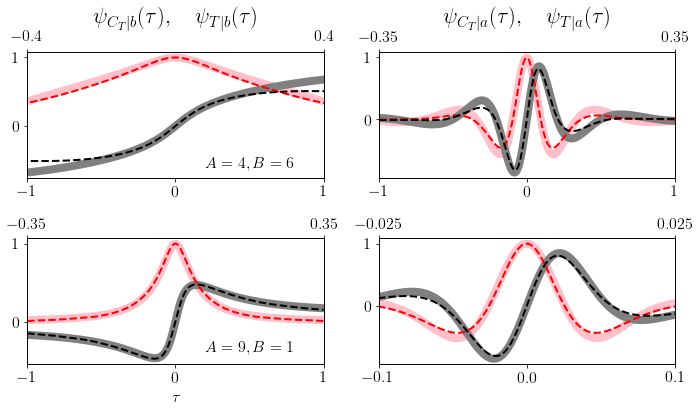

In [16]:
with np.load("bipartite_sims_5.npz") as data:
    S_fix = data['S_fix']; S_ext = data['S_ext']; cfasim = data['cfasim']; cfbsim = data['cfbsim'];
    C_fix = data['C_fix']; C_ext = data['C_ext'];
    A = data['A']; B = data['B']; r = data['r']; Sa0 = data['Sa0']; Sb0 = data['Sb0']; tau = data['tau']
    cfaT = data['cfaT']; cfbT = data['cfbT']
    
h = np.exp(tau)    

#calculate theoretical CCFs
psia,psib,p = psi(A,B,r,Sa0,Sb0,h);

fig = plt.subplots(figsize=(10,6))
ax1 = plt.subplot(221); ax2 = plt.subplot(222); ax3 = plt.subplot(223); ax4 = plt.subplot(224)
ax1b = ax1.twiny(); ax2b = ax2.twiny(); ax3b = ax3.twiny(); ax4b = ax4.twiny()

ax1.plot(np.imag(tau),np.real(psib),color = 'pink',lw=8)
ax1.plot(np.imag(tau),np.imag(psib),color='gray',lw=8)
ax1.set_xticks([-1,0,1]); ax1.set_xlim([-1,1])
ax1.set_title(r'$\psi_{C_T|b}(\tau), \quad \psi_{T|b}(\tau)$',fontsize=22)
ax1b.plot(np.imag(tau),np.real(cfbT),color='r',lw=2,ls='--')
ax1b.plot(np.imag(tau),np.imag(cfbT),color='k',lw=2,ls='--')
ax1b.set_xticks([-.4,.4]); ax1b.set_xlim([-.4,.4])
ax1.set_yticks([0,1])
ax1.text(.2,-.6,r'$A=4,B=6$')

ax2.plot(np.imag(tau),np.real(psia),color = 'pink',lw=8)
ax2.plot(np.imag(tau),np.imag(psia),color='gray',lw=8)
ax2.set_title(r'$\psi_{C_T|a}(\tau), \quad \psi_{T|a}(\tau)$',fontsize=22)
ax2b.plot(np.imag(tau),np.real(cfaT),color='r',lw=2,ls='--')
ax2b.plot(np.imag(tau),np.imag(cfaT),color='k',lw=2,ls='--')
ax2b.set_xlim([-.35,.35]); ax2b.set_xticks([-.35,.35])
ax2.set_xlim([-1,1]); ax2.set_xticks([-1,0,1]); ax2.set_yticks([0,1])


with np.load("bipartite_sims_6.npz") as data:
    S_fix = data['S_fix']; S_ext = data['S_ext']; cfasim = data['cfasim']; cfbsim = data['cfbsim'];
    C_fix = data['C_fix']; C_ext = data['C_ext'];
    A = data['A']; B = data['B']; r = data['r']; Sa0 = data['Sa0']; Sb0 = data['Sb0']; tau = data['tau']
    cfaT = data['cfaT']; cfbT = data['cfbT']
    
h = np.exp(tau)    

#calculate theoretical CCFs
psia,psib,p = psi(A,B,r,Sa0,Sb0,h);

ax3.plot(np.imag(tau),np.real(psib),color = 'pink',lw=8)
ax3.plot(np.imag(tau),np.imag(psib),color='gray',lw=8)
ax3.set_xticks([-1,0,1]); ax3.set_xlim([-1,1])
ax3b.plot(np.imag(tau),np.real(cfbT),color='r',lw=2,ls='--')
ax3b.plot(np.imag(tau),np.imag(cfbT),color='k',lw=2,ls='--')
ax3b.set_xticks([-.35,.35]); ax3b.set_xlim([-.35,.35])
ax3.set_yticks([0,1])
ax3.set_xlabel(r'$\tau$')
ax3.text(.2,-.38,r'$A=9,B=1$')

ax4.plot(np.imag(tau),np.real(psia),color = 'pink',lw=8)
ax4.plot(np.imag(tau),np.imag(psia),color='gray',lw=8)
ax4b.plot(np.imag(tau),np.real(cfaT),color='r',lw=2,ls='--')
ax4b.plot(np.imag(tau),np.imag(cfaT),color='k',lw=2,ls='--')
ax4b.set_xlim([-.025,.025]); ax4b.set_xticks([-.025,.025])
ax4.set_xlim([-.1,.1]); ax4.set_xticks([-.1,0,.1]); ax4.set_yticks([0,1])


plt.tight_layout()
plt.savefig('time2.pdf',bbox_inches='tight')